In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input,Dense, LSTM,Embedding,Dropout,add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'

In [3]:
#extracting image features
model=VGG16()

model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
features={}
directory=os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature
    

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
features['3226254560_2f8ac147ea'].shape

(1, 4096)

In [6]:
import pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [7]:
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
    features=pickle.load(f)

In [9]:
#load the caption data
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()
    

In [10]:
mapping={}
for line in tqdm(captions_doc.split('\n')):
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    image_id=image_id.split('.')[0]
    caption=' '.join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            
            caption=caption.lower()
            
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq '+' '.join([word for word in caption.split() if len(word)>1])+' end'
            captions[i]=caption

In [13]:
mapping['3226254560_2f8ac147ea']

['A dog in a snowy area .',
 'A spotted dog catching a ball on a snowy field .',
 'A white and brown spotted dog runs along the snow to catch a ball .',
 'A white dog is running fast on a trail covered by snow .',
 'The brown and white dog is playing in the snow .']

In [14]:
clean(mapping)

In [15]:
mapping['3226254560_2f8ac147ea']

['startseq dog in snowy area end',
 'startseq spotted dog catching ball on snowy field end',
 'startseq white and brown spotted dog runs along the snow to catch ball end',
 'startseq white dog is running fast on trail covered by snow end',
 'startseq the brown and white dog is playing in the snow end']

In [16]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [19]:
vocab_size

8484

In [20]:
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
#split ratio
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
split

7281

In [22]:
train=image_ids[:split]
test=image_ids[split:]

In [24]:
<start> girl going into wooden building <end>
       x(input)                 y(predicted)
<start>                        girl
girl                             going
girl going                       into
.....
girl going into wooden building         <end>

SyntaxError: invalid syntax (3688989310.py, line 1)

In [23]:
#create a data generator to get the data in batch to avoid session crash
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocal_size,batch_size):
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            captions=mapping[key]
            for caption in captions:
                #encoder the sequece
                seq=tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into x, y part
                for i in range(1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n==batch_size:
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield[X1,X2],y
                X1,X2,y=list(),list(),list()
                n=0
                

In [24]:
tokenizer.texts_to_sequences(['<start> dog in snowy area <end>'])[0]

[2045, 8, 3, 141, 152, 1]

In [33]:
seq=tokenizer.texts_to_sequences(['<start> girl going into wooden building <end>'])[0]
#split the sequence into x, y part
for i in range(1,len(seq)):
    in_seq,out_seq=seq[:i],seq[i:]
#     print(pad_sequences([in_seq],maxlen=max_length)[0].shape)
    print(out_seq)
    print(np.asarray(to_categorical([out_seq],num_classes=vocab_size)[0]).dtype)

[18, 316, 64, 196, 117, 1]
float32
[316, 64, 196, 117, 1]
float32
[64, 196, 117, 1]
float32
[196, 117, 1]
float32
[117, 1]
float32
[1]
float32


#### inputs1=Input(shape=(4.96,0))


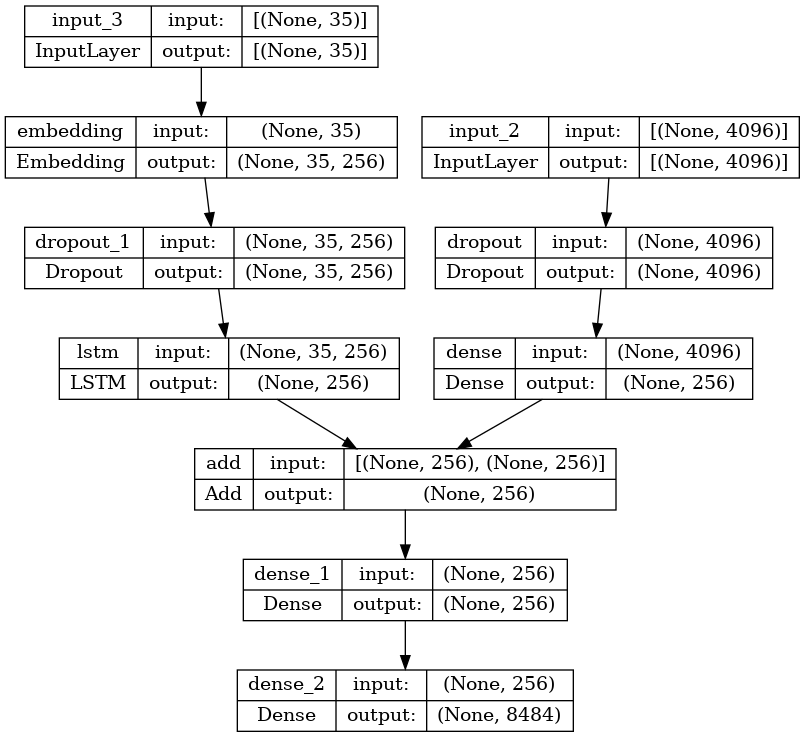

In [25]:
#encoding
#image feature layer
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence feature layer
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

#decoder
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True)

In [26]:
epochs=15
batch_size=64
steps=len(train)//batch_size
for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

113/113 [==============================] - 61s 537ms/step - loss: 2.4961


In [27]:
model.save('best_model.h5')

In [28]:
#generate caption for the images
def idk_to_words(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [34]:
#generate captions of an image
def predict_caption(model,image,tokenizer,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],max_length)
        yhat=model.predict([image,sequence],verbose=0)
        yhat=np.argmax(yhat)
        word=idk_to_words(yhat,tokenizer)
        if word is None:
            break
        in_text+=' '+word
        if word=='end':
            break
    return in_text

In [35]:
# from nltk.translate.bleu_score import corpus_bleu
# actual,predicted=list(),list()
# for key in tqdm(test):
#     captions=mapping[key]
#     y_pred=predict_caption(model,features[key],tokenizer,max_length)
#     actual_captions=[caption.split() for caption in captions]
#     actual.append(actual_captions)
#     predicted.append(y_pred.split())
    
# print('BLEU-1: %f'%corpus_bleu(actual,predicted,weights=[1.0,0,0,0]))
# print('BLEU-1: %f'%corpus_bleu(actual,predicted,weights=[0.5,0.5,0,0]))

In [36]:
#visualize the results
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):

    image_id=image_name.split('.')[0]
    img_path=os.path.join(BASE_DIR,'Images',image_name)
    image=Image.open(img_path)
    captions=mapping[image_id]
    print('-------------------Acutal-----------------')
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
    print('----------------------predicted-------------------')
    print(y_pred)
    plt.imshow(image)
    

-------------------Acutal-----------------
startseq collage of one person climbing cliff end
startseq group of people are rock climbing on rock climbing wall end
startseq group of people climbing rock while one man belays end
startseq seven climbers are ascending rock face whilst another man stands holding the rope end
startseq several climbers in row are climbing the rock while the man in red watches and holds the line end
----------------------predicted-------------------
startseq collage of people are climbing on stone wall end


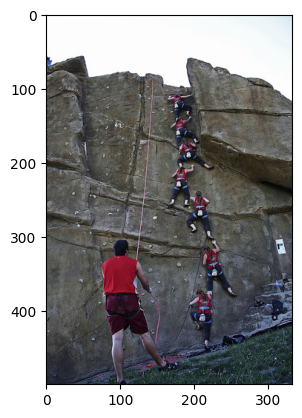

In [42]:
image_name='1016887272_03199f49c4.jpg'
generate_caption(image_name)